# Demo

In [1]:
import numpy as np
import time
import scipy as sp
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from bayesbridge import BayesBridge, RegressionModel, RegressionCoefPrior
from bayesbridge import HorseshoePrior
from simulate_data import simulate_design, simulate_outcome
from util import mcmc_summarizer

## BayesBridge supports both dense (numpy array) and sparse (scipy sparse matrix) design matrices.

In [3]:
n_obs, n_pred = 10 ** 4, 10 ** 3

X = simulate_design(
    n_obs, n_pred, 
    binary_frac=.9,
    binary_pred_freq=.2,
    shuffle_columns=True,
    format_='sparse',
    seed=111
)

In [4]:
beta_true = np.zeros(n_pred)
beta_true[:5] = 1.5
beta_true[5:10] = 1.
beta_true[10:15] = .5

n_trial = np.ones(X.shape[0]) # Binary outcome.
y = simulate_outcome(
    X, beta_true, intercept=0., 
    n_trial=n_trial, model='logit', seed=1
)

## Horseshoe prior

In [5]:
model = RegressionModel(
    y, X, family='logit',
    add_intercept=True, center_predictor=True,
        # Do *not* manually add intercept to or center X.
)

prior = HorseshoePrior(
    n_fixed_effect=0,
    sd_for_intercept=float('inf'),
    sd_for_fixed_effect=1,
    regularizing_slab_size=2.,
    skew_mean=0.,
    skew_sd=1.,
    global_scale_prior=None,
    centered=False,
)

bridge = BayesBridge(model, prior)

/Users/gracexd/Documents/github/bayes-bridge-dev/bayesbridge/design_matrix/sparse_matrix.py:34: UserWarning: Could not load MKL Library. Will use Scipy's 'dot'.


## Run the Gibbs sampler.

In [6]:
samples, mcmc_info = bridge.gibbs(
    n_iter=50, n_burnin=0, thin=1, 
    init={'global_scale': .01},
    coef_sampler_type='cg',
    seed=111
)

In [7]:
np.sum(samples['coef'] / samples['global_scale'] / np.sqrt(2) == 0)

0

In [8]:
samples['coef'].shape

(1001, 50)

(array([5.0000e+00, 1.3000e+01, 5.7000e+01, 4.3700e+02, 2.3780e+03,
        1.0290e+04, 2.2937e+04, 1.1903e+04, 1.4900e+03, 5.4000e+02]),
 array([-6.28034807, -5.38127902, -4.48220997, -3.58314092, -2.68407187,
        -1.78500282, -0.88593377,  0.01313528,  0.91220433,  1.81127338,
         2.71034243]),
 <BarContainer object of 10 artists>)

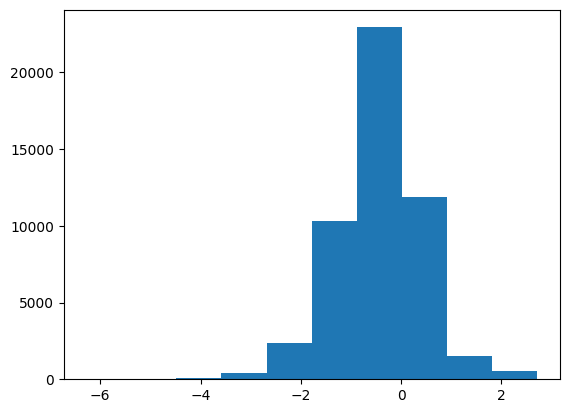

In [9]:
plt.hist(np.log10(np.abs(samples['coef'] / samples['global_scale'] / np.sqrt(2))).flatten())

In [10]:
samples['coef']

array([[ 1.29927439e+00,  1.28905368e+00,  1.38931908e+00, ...,
         1.89468846e+00,  1.89551900e+00,  1.89176513e+00],
       [ 6.24133604e-03,  9.56806515e-04,  8.46343435e-04, ...,
         1.25687738e+00,  1.33589414e+00,  1.27555893e+00],
       [ 1.17233350e-02,  4.03062194e-02,  1.57551094e-01, ...,
         1.78792749e+00,  1.65430426e+00,  1.81349766e+00],
       ...,
       [-5.59994399e-04,  2.26389714e-03, -1.23858882e-02, ...,
         1.68402836e-03,  5.78857044e-03,  3.88186434e-03],
       [-3.13996400e-03, -2.16602043e-03,  2.02535049e-03, ...,
        -1.17416438e-04,  2.84876143e-04, -4.38857406e-04],
       [ 3.71571995e-04, -2.91905057e-03,  6.79470557e-02, ...,
         8.65329313e-02,  9.34186946e-02,  7.25454813e-02]])

In [11]:
samples['global_scale']

array([0.00654561, 0.00538081, 0.00474387, 0.00439413, 0.00448376,
       0.00447891, 0.00440042, 0.00430844, 0.00413382, 0.00413343,
       0.00428882, 0.00412018, 0.0040338 , 0.00402469, 0.00393831,
       0.00391137, 0.00385102, 0.00389964, 0.00380283, 0.00393729,
       0.00396558, 0.00405254, 0.00394059, 0.00387623, 0.00382649,
       0.00389361, 0.00375858, 0.0038802 , 0.003691  , 0.00358054,
       0.003492  , 0.00340237, 0.00355779, 0.00346458, 0.00349772,
       0.0034107 , 0.00347394, 0.00362551, 0.00335117, 0.00336636,
       0.00351166, 0.00347201, 0.00354883, 0.00339108, 0.00335564,
       0.0034012 , 0.00338993, 0.00336958, 0.00347625, 0.00360387])

In [12]:
%who

BayesBridge	 HorseshoePrior	 RegressionCoefPrior	 RegressionModel	 X	 beta_true	 bridge	 mcmc_info	 mcmc_summarizer	 
model	 n_obs	 n_pred	 n_trial	 np	 plt	 prior	 samples	 scipy	 
simulate_design	 simulate_outcome	 sp	 time	 y	 


Check convergence by looking at the traceplot for posterior log-density.

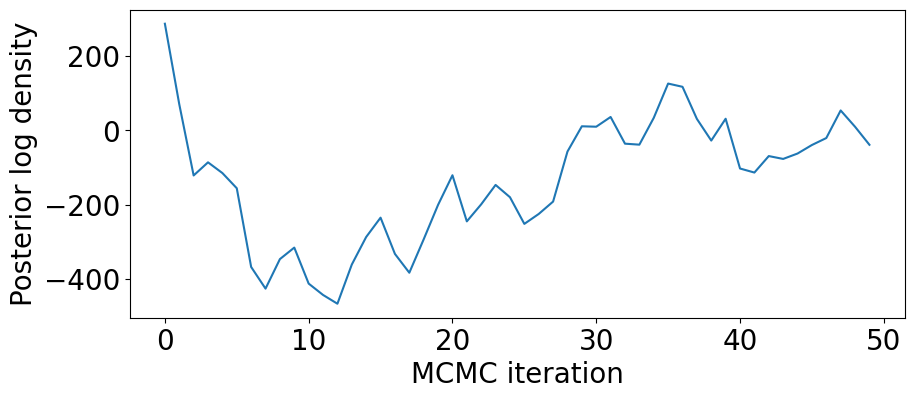

In [12]:
plt.figure(figsize=(10, 4))
plt.rcParams['font.size'] = 20

plt.plot(samples['logp'])
plt.xlabel('MCMC iteration')
plt.ylabel('Posterior log density')
plt.show()

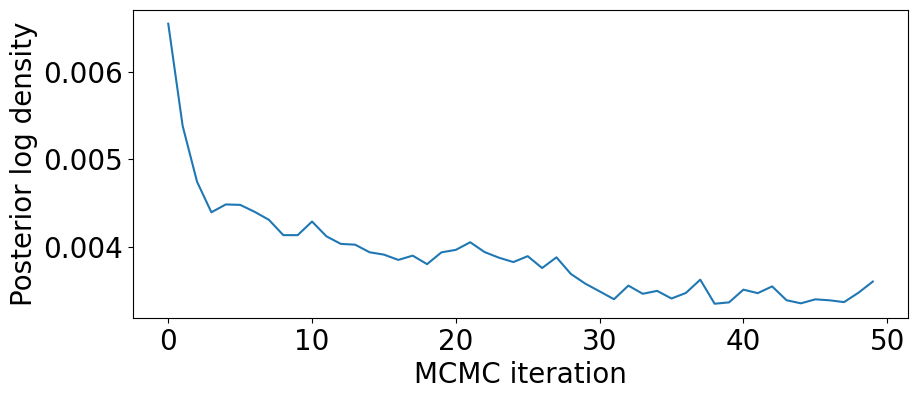

In [13]:
plt.figure(figsize=(10, 4))
plt.rcParams['font.size'] = 20

plt.plot(samples['global_scale'])
plt.xlabel('MCMC iteration')
plt.ylabel('Global Scale')
plt.show()

## Restart MCMC from the last iteration with 'gibbs_resume()'.

In [14]:
samples, mcmc_info = bridge.gibbs_resume(
    mcmc_info, n_add_iter=250
)

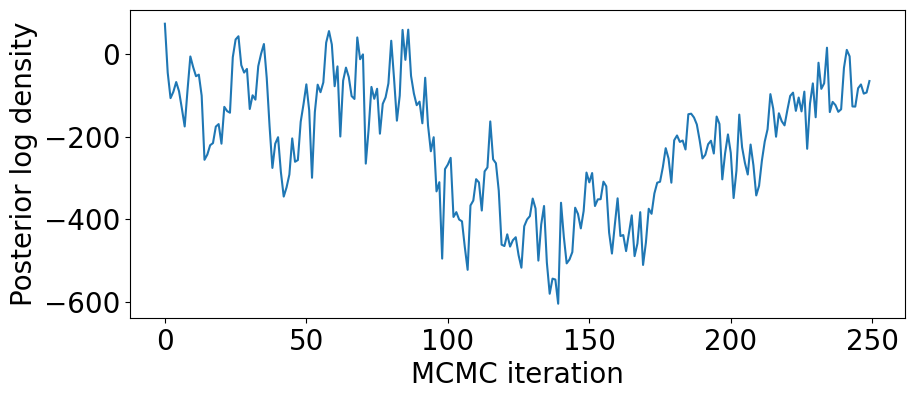

In [17]:
plt.figure(figsize=(10, 4))
plt.rcParams['font.size'] = 20

plt.plot(samples['logp'])
plt.xlabel('MCMC iteration')
plt.ylabel('Posterior log density')
plt.show()

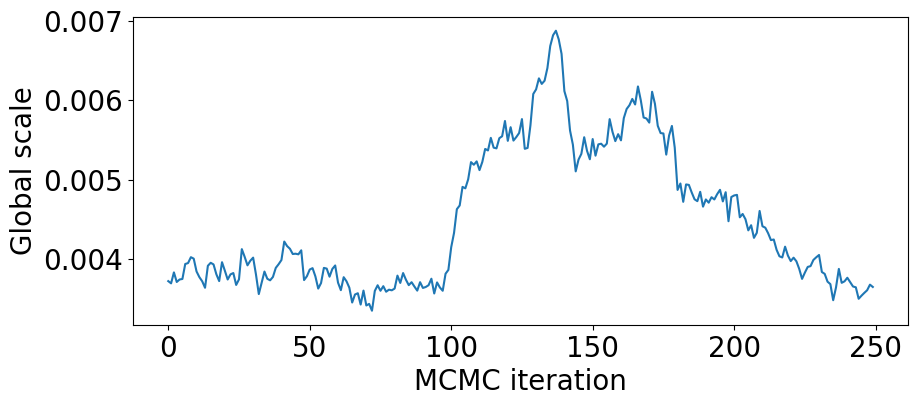

In [18]:
plt.figure(figsize=(10, 4))
plt.rcParams['font.size'] = 20

plt.plot(samples['global_scale'])
plt.xlabel('MCMC iteration')
plt.ylabel('Global scale')
plt.show()

Add more samples (while keeping the previous ones) with 'merge=True'.

In [19]:
samples, mcmc_info = bridge.gibbs_resume(
    mcmc_info, n_add_iter=750, merge=True, prev_samples=samples
)
coef_samples = samples['coef'][1:, :] # Extract all but the intercept

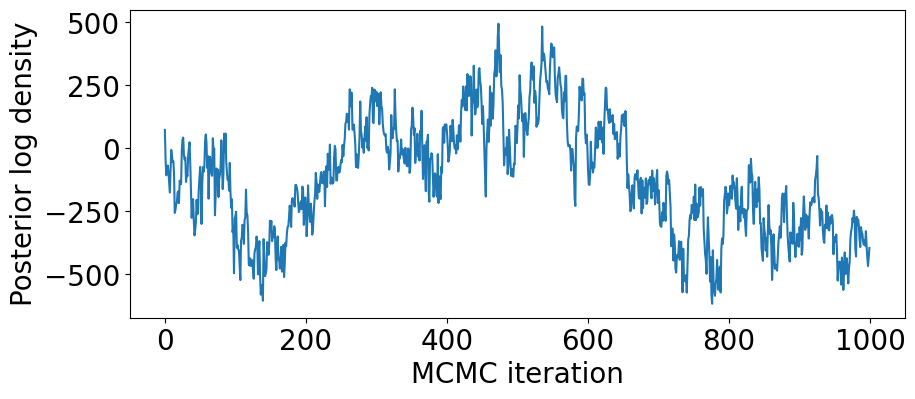

In [22]:
plt.figure(figsize=(10, 4))
plt.rcParams['font.size'] = 20

plt.plot(samples['logp'])
plt.xlabel('MCMC iteration')
plt.ylabel('Posterior log density')
plt.show()

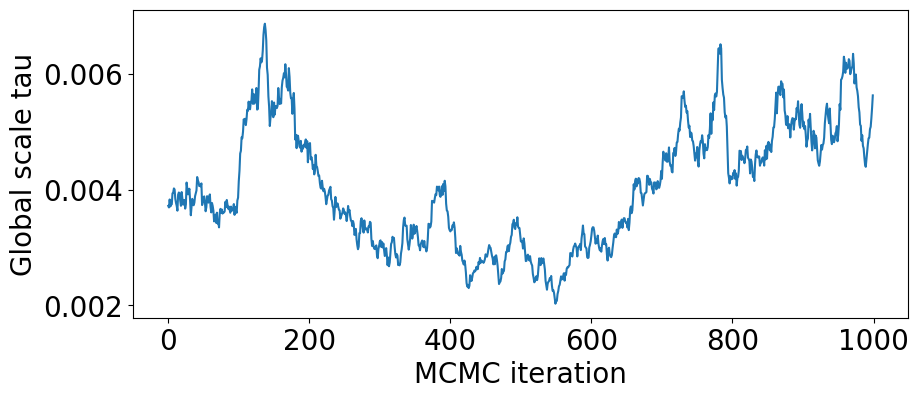

In [23]:
plt.figure(figsize=(10, 4))
plt.rcParams['font.size'] = 20

plt.plot(samples['global_scale'])
plt.xlabel('MCMC iteration')
plt.ylabel('Global scale tau')
plt.show()

## Check mixing of regression coefficients and their posterior marginals.

Typically the convergence is quick and mixing of the regression coefficients is adequate.

In [24]:
coef_samples = samples['coef'][1:, :] # Extract all but the intercept

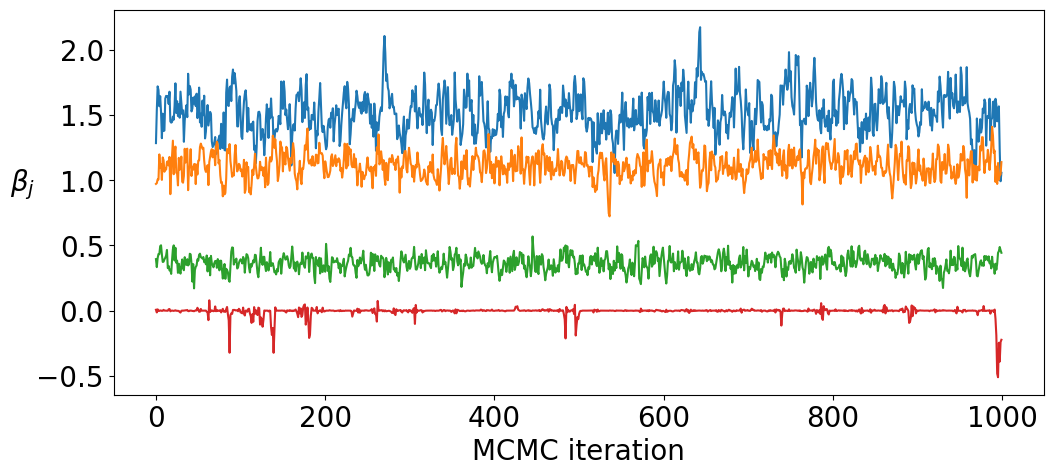

In [25]:
plt.figure(figsize=(12, 5))
plt.rcParams['font.size'] = 20

plt.plot(coef_samples[[0, 5, 10, 15], :].T)
plt.xlabel('MCMC iteration')
plt.ylabel(r'$\beta_j$', rotation=0, labelpad=10)
plt.show()

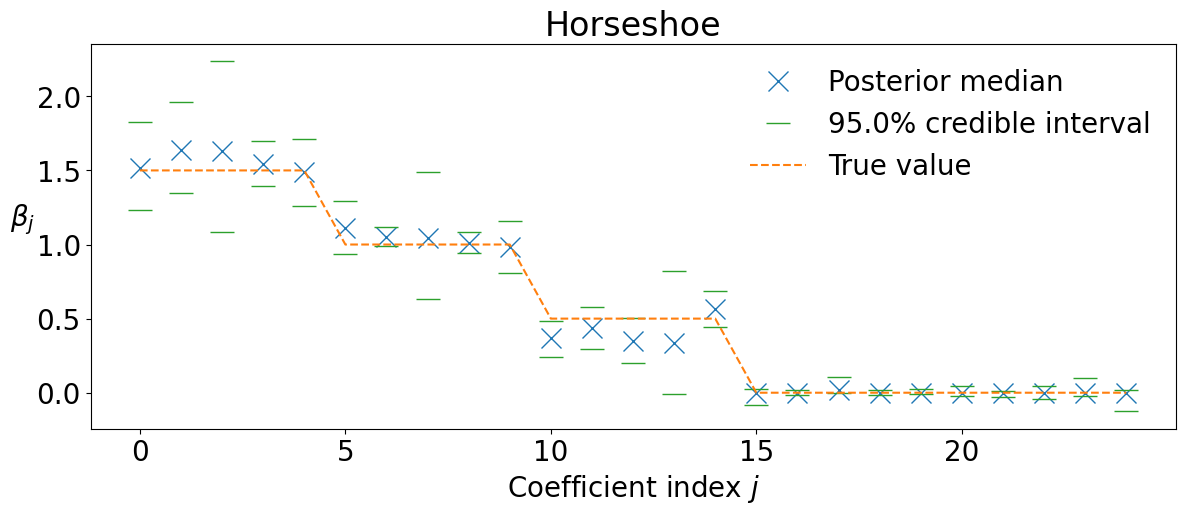

In [26]:
plt.figure(figsize=(14, 5))
plt.rcParams['font.size'] = 20

n_coef_to_plot = 25

mcmc_summarizer.plot_conf_interval(
    coef_samples, conf_level=.95, 
    n_coef_to_plot=n_coef_to_plot, marker_scale=1.4
);
plt.plot(
    beta_true[:n_coef_to_plot], '--', color='tab:orange',
    label='True value'
)
plt.title('Horseshoe')
plt.xlabel(r'Coefficient index $j$')
plt.ylabel(r'$\beta_j$', rotation=0, labelpad=10)
plt.xticks([0, 5, 10, 15, 20])
plt.legend(frameon=False)

plt.show()